In [1]:
import os
import time
import uuid
import cv2


In [2]:
#Specify the path to the images
IMAGES_PATH = os.path.join('data', 'images')
images_number = 30

In [6]:
# Collecting the actual images
cap = cv2.VideoCapture(0)
for imgnum in range(images_number):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [7]:
!labelme

^C


In [8]:
#Review Dataset and Build Image Loading Function
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#Limit GPU Memory Growth
#Avoiding OOM errors by setting the GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
print(tf.config.list_physical_devices('GPU'))

[]


In [49]:
# Load Image into to TF Data Pipeline

images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [50]:
images.as_numpy_iterator().next()

b'data\\images\\212d1ad8-d6a9-11ef-9d1c-047c163d1efe.jpg'

In [51]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [52]:
images = images.map(load_image)

In [53]:
images.as_numpy_iterator().next()

array([[[ 83,  94,  90],
        [ 81,  92,  88],
        [ 79,  90,  84],
        ...,
        [ 95, 111, 108],
        [ 93, 109, 108],
        [ 89, 108, 106]],

       [[ 81,  92,  88],
        [ 80,  91,  87],
        [ 78,  89,  85],
        ...,
        [ 95, 111, 108],
        [ 95, 111, 110],
        [ 92, 111, 109]],

       [[ 83,  92,  91],
        [ 81,  90,  89],
        [ 79,  89,  88],
        ...,
        [ 95, 112, 106],
        [ 96, 112, 109],
        [ 93, 112, 108]],

       ...,

       [[ 83, 103, 104],
        [ 82, 102, 101],
        [ 83, 101, 101],
        ...,
        [ 63,  68,  62],
        [ 68,  70,  65],
        [ 64,  66,  61]],

       [[ 82, 101, 105],
        [ 82, 102, 103],
        [ 84, 102, 104],
        ...,
        [ 66,  71,  65],
        [ 73,  76,  69],
        [ 67,  70,  63]],

       [[ 82, 101, 105],
        [ 82, 101, 105],
        [ 84, 102, 104],
        ...,
        [ 71,  76,  70],
        [ 73,  76,  69],
        [ 73,  76,  69]]

In [54]:
#View Raw Images with Matplotlib
image_generator = images.batch(4).as_numpy_iterator()

In [78]:
plot_images = image_generator.next()

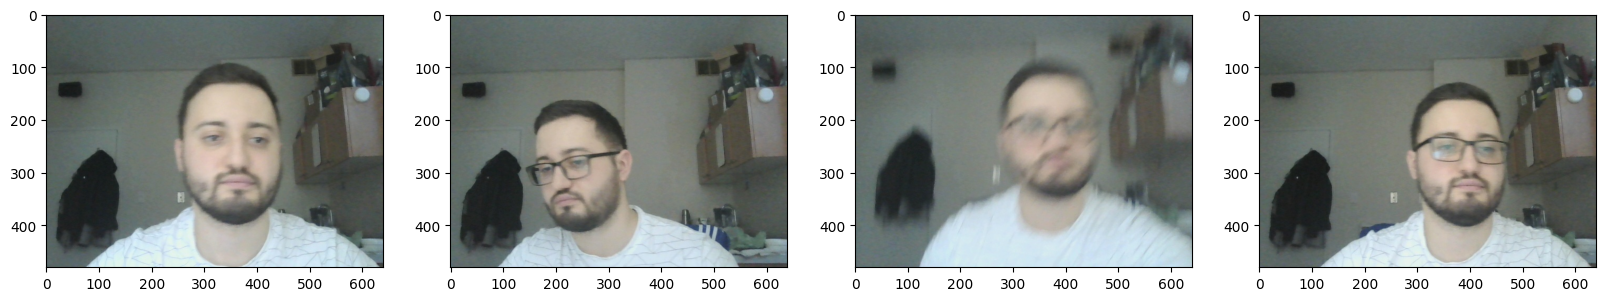

In [79]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()    

### Partition Unaugmented Data

MANUALLY SPLIT DATA INTO TRAIN TEST AND VAL

In [ ]:
# 83 to train
# 19 and 18 to test and val respectively

Move the matching Labels

In [80]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

### Apply Image Augmentation on Images and Labels using Albumentations

In [81]:
import albumentations as alb

In [83]:
# Augmentation Pipeline
augmentor = alb.Compose([
                        alb.RandomCrop(width=450, height=450),
                        alb.HorizontalFlip(p=0.5), alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2), alb.RGBShift(p=0.2), alb.VerticalFlip(p=0.5)
                        ],
                        bbox_params=alb.BboxParams(format='albumentations', 
                        label_fields=['class_labels']))

In [87]:
img = cv2.imread(os.path.join('data', 'train', 'images', '1a19b496-d6a9-11ef-85da-047c163d1efe.jpg'))
print(img)

[[[104 101  97]
  [103 100  96]
  [101 100  96]
  ...
  [120 121 112]
  [122 119 111]
  [121 118 110]]

 [[104 101  97]
  [101 100  96]
  [101 100  96]
  ...
  [117 118 109]
  [120 117 109]
  [119 117 107]]

 [[102 100  99]
  [ 99 100  98]
  [ 98  99  97]
  ...
  [116 117 107]
  [119 117 107]
  [119 117 106]]

 ...

 [[110 107  99]
  [110 107  99]
  [110 107  99]
  ...
  [ 68  69  67]
  [ 71  69  69]
  [ 70  68  67]]

 [[112 107  98]
  [112 107  98]
  [112 107  98]
  ...
  [ 72  73  69]
  [ 73  71  70]
  [ 72  71  67]]

 [[111 106  97]
  [112 107  98]
  [113 108  99]
  ...
  [ 71  72  68]
  [ 74  73  69]
  [ 77  76  72]]]


In [88]:
# Load the annotation
import json
with open(os.path.join('data', 'train', 'labels', '1a19b496-d6a9-11ef-85da-047c163d1efe.json'), 'r') as f:
    label = json.load(f)

In [89]:
label

{'version': '5.6.0',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[306.98924731182797, 184.89247311827958],
    [459.13978494623655, 394.5698924731183]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\1a19b496-d6a9-11ef-85da-047c163d1efe.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAV

Extract Coordinates and Rescale to Match Image Resolution

In [90]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [92]:
coords

[306.98924731182797, 184.89247311827958, 459.13978494623655, 394.5698924731183]

In [93]:
# Divide the coordinates by the width and height of the image
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [94]:
coords

[np.float64(0.4796706989247312),
 np.float64(0.38519265232974914),
 np.float64(0.7174059139784946),
 np.float64(0.8220206093189965)]

Apply Augmentations and View Results

In [95]:
augmented_result = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [99]:
augmented_result['image'].shape

(450, 450, 3)

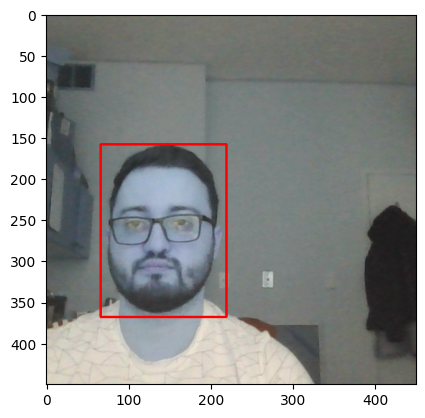

In [100]:
import matplotlib.pyplot as plt
cv2.rectangle(augmented_result['image'],
              tuple(np.multiply(augmented_result['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented_result['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0),
              2
              )
plt.imshow(augmented_result['image'])

Run Augmentation Pipeline

In [101]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]    
            coords = list(np.divide(coords, [640, 480, 640, 480]))
            
        try:
               for x in range(60):
                   augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                   cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                   
                   annotation = {}
                   annotation['image'] = image
                   
                   if os.path.exists(label_path):
                       if len(augmented['bboxes']) == 0:
                           annotation['bbox'] = [0, 0, 0, 0]
                           annotation['class'] = 0
                       else:
                           annotation['bbox'] = augmented['bboxes'][0]
                           annotation['class'] = 1
                           
                   else:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    
                   with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                        json.dump(annotation, f)
                        
        except Exception as e:
            print(e)                               

Load Augmented Images to Tensorflow Dataset

We resize the images, since it can improve the effectivness of the NN

In [102]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255) # scaling the images

In [103]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [104]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [105]:
train_images.as_numpy_iterator().next()

array([[[0.74938726, 0.8160539 , 0.8459559 ],
        [0.7579044 , 0.82101715, 0.84552693],
        [0.7765319 , 0.8353554 , 0.8628064 ],
        ...,
        [0.3735294 , 0.41421568, 0.42432597],
        [0.38284314, 0.41960785, 0.41605392],
        [0.39074755, 0.4186887 , 0.40447304]],

       [[0.72408086, 0.7946691 , 0.81035537],
        [0.7685662 , 0.82726717, 0.8469363 ],
        [0.7742034 , 0.8251838 , 0.8487132 ],
        ...,
        [0.36911765, 0.42009804, 0.44362745],
        [0.39019608, 0.43480393, 0.45      ],
        [0.39718136, 0.43676472, 0.44050246]],

       [[0.7333946 , 0.8000613 , 0.82751226],
        [0.7104167 , 0.7682598 , 0.796201  ],
        [0.77732843, 0.8283088 , 0.85968137],
        ...,
        [0.3803309 , 0.41660538, 0.44356617],
        [0.38731617, 0.42261028, 0.44319853],
        [0.39068627, 0.42371324, 0.43756127]],

       ...,

       [[0.39313725, 0.44019607, 0.4245098 ],
        [0.39313725, 0.4357843 , 0.42156863],
        [0.41127452, 0

### Prepare Labels

In [106]:
#Load the labels
import json
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']    

In [107]:
#Load labels to TF Dataset
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [108]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [109]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [110]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.03345, 0.1578 , 0.4492 , 0.65   ], dtype=float16))

Check partitions length

In [113]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels),

(4980, 4980, 1140, 1140, 1080, 1080)

Create Final Datasets (Images/Labels)

In [114]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5500)
train = train.batch(8)
train = train.prefetch(4)

In [115]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test = test.prefetch(4)

In [116]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1200)
val = val.batch(8)
val = val.prefetch(4)

In [119]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.04123, 0.2388 , 0.6675 , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.3567 , 0.1335 , 0.8467 , 0.798  ],
        [0.617  , 0.0785 , 1.     , 0.695  ],
        [0.361  , 0.1035 , 0.9536 , 0.8706 ],
        [0.2644 , 0.135  , 0.6167 , 0.6177 ],
        [0.3667 , 0.2305 , 0.864  , 0.914  ],
        [0.5073 , 0.0897 , 1.     , 0.804  ]], dtype=float16))

View Images and Annotations

In [120]:
data_samples = train.as_numpy_iterator()


In [133]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


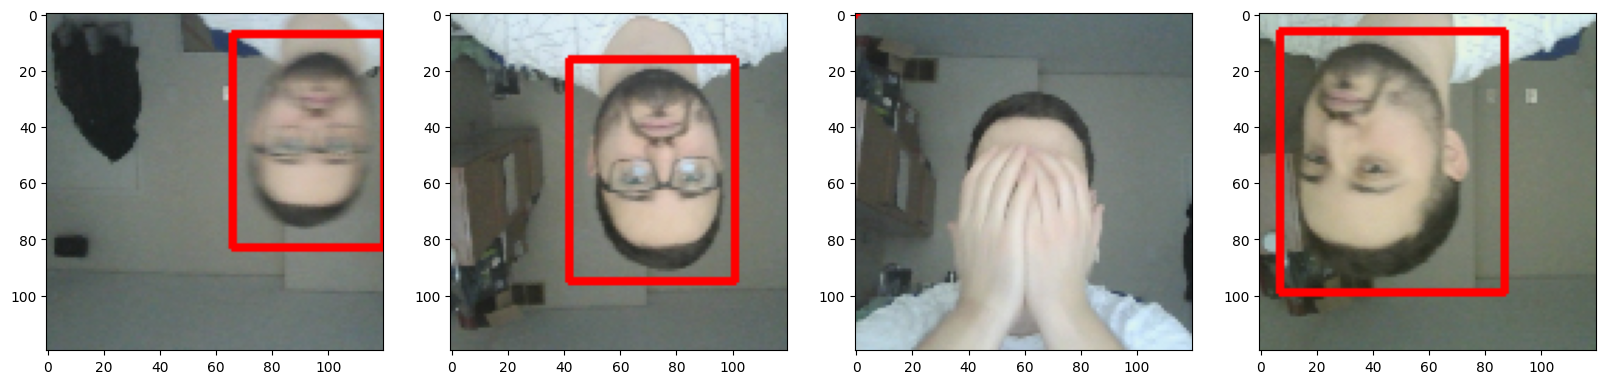

In [134]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
                 tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                 tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                 (255, 0, 0), 2 
                  )
    
    ax[idx].imshow(sample_image)
    
plt.show()